In [1]:
# %% Load the required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sage import SAGEConv
import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# %% data loading and pre-processing

df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
features = pd.Series(X.satisfaction) 
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

TEST = pd.read_csv('TEST_DF')
test_features = pd.Series(TEST.satisfaction)
test_vars = TEST.drop(columns=['Unnamed: 0','satisfaction'])
test_vars.Class = test_vars.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
test_wd = pd.get_dummies(data=test_vars,columns=['Customer Type','Type of Travel','Gender'])
test_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(test_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [4]:
# %%  load graph data

A = np.loadtxt('adjacency_matrix.csv',delimiter=',')
G = nx.from_numpy_matrix(A)
A_test = np.loadtxt('adjacency_matrix_test_graph.csv',delimiter=',')
G_test = nx.from_numpy_matrix(A_test)

In [5]:
# %% Normalization function

def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [6]:
# %% GraphSage Class

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, agg_type):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [7]:
# %% SumSage Class for sum-pooling

class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [14]:
# %% Simulation function

def Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False):

    train_acc_exp = []
    val_acc_exp = []
    exp_losses_train = []
    exp_losses_val = []
    test_acc = []
    plot_loss_test = []
    

    G_dgl_test = dgl.from_networkx(G_test)
    feat_test = TEST.drop(columns=['satisfaction'])
    feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
    feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

    G_dgl_test.ndata['feat'] =  torch.tensor(test_wd.values,dtype=torch.float)
    G_dgl_test.ndata['label'] = torch.tensor(test_features)
    
    node_features_test = G_dgl_test.ndata['feat']
    node_labels_test = G_dgl_test.ndata['label']
    test_nids = G_dgl_test.nodes()
    n_features_test = node_features_test.shape[1]
    n_labels_test = int(node_labels_test.max().item() + 1)
    
    for n in range(nExp):
        print('Experiment: {}'.format(n))
        
        G_dgl = dgl.from_networkx(G)
        G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
        G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
        G_dgl.ndata['label'] = torch.tensor(features)

        G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
        for i in range(len(G_dgl.ndata['train_mask'])):
            if G_dgl.ndata['train_mask'][i] == True:
                G_dgl.ndata['val_mask'][i] = False
            else:
                G_dgl.ndata['val_mask'][i] = True

        G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

        node_features = G_dgl.ndata['feat']
        node_labels = G_dgl.ndata['label']
        train_mask = G_dgl.ndata['train_mask']
        valid_mask = G_dgl.ndata['val_mask']
        n_features = node_features.shape[1]
        n_labels = int(node_labels.max().item() + 1)

        train_nodes = (train_mask == True).nonzero(as_tuple=False)
        train_nids = torch.reshape(train_nodes,(-1,))
        valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
        valid_nids = torch.reshape(valid_nodes,(-1,))

        batch_size = 50
        sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
        train_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, train_nids, sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0
        )

        batch_size = len(valid_nids)
        valid_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, valid_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )

        if sum_sage is True:
            model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
        else:
            model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type) #n_layers
        opt = torch.optim.Adam(model.parameters(), lr=0.002)


        best_accuracy = 0
        epoch_losses_train = []
        plot_loss_valid = []
        train_acc = []
        valid_acc = []
        dur = []

        for epoch in range(400):
            t0 = time.time()
            model.train()
            loss_epoch = 0
            accuracy_epoch = 0
            for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
                inputs = node_features[input_nodes]
                labels = node_labels[output_nodes]
                predictions = model(bipartites, inputs)

                loss = F.cross_entropy(predictions, labels)
                loss_epoch += loss.detach().item()
                opt.zero_grad()
                loss.backward()
                opt.step()

                accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
                accuracy_epoch += accuracy
            accuracy_epoch /= (step + 1)
            loss_epoch /= (step + 1)
            epoch_losses_train.append(loss_epoch)
            train_acc.append(accuracy_epoch)
            print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
            model.eval()
    
            predictions = []
            labels = []
            with torch.no_grad():
                for input_nodes, output_nodes, bipartites in valid_dataloader:
                    inputs = node_features[input_nodes]
                    labels.append(node_labels[output_nodes].numpy())
                    predictions.append(model(bipartites, inputs).argmax(1).numpy())
                    valid_pred = model(bipartites, inputs)
                    valid_labels = node_labels[output_nodes]
                    valid_loss = F.cross_entropy(valid_pred, valid_labels)

                predictions = np.concatenate(predictions)
                labels = np.concatenate(labels)
        
                accuracy = accuracy_score(labels, predictions)
                dur.append(time.time() - t0)
                print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
                valid_acc.append(accuracy.item())
                plot_loss_valid.append(valid_loss.item())

        train_acc_exp.append(train_acc[-1])
        val_acc_exp.append(valid_acc[-1])
        exp_losses_train.append(epoch_losses_train[-1])
        exp_losses_val.append(plot_loss_valid[-1])
        
        batch_size = len(test_nids)
        test_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl_test, test_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )
        
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for input_nodes, output_nodes, bipartites in test_dataloader:
                inputs = node_features_test[input_nodes]
                test_labels.append(node_labels_test[output_nodes].numpy())
                test_predictions.append(model(bipartites, inputs).argmax(1).numpy())
                test_pred = model(bipartites, inputs)
                test_lab = node_labels_test[output_nodes]
                test_loss = F.cross_entropy(test_pred, test_lab)

            test_predictions = np.concatenate(test_predictions)
            test_labels = np.concatenate(test_labels)
        
            test_accuracy = accuracy_score(test_labels, test_predictions)
            print('Epoch: {}, Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(epoch, test_accuracy, test_loss.item()))
            test_acc.append(test_accuracy.item())
            plot_loss_test.append(test_loss.item())
        

    return (train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_acc, plot_loss_test)


In [20]:
# %% Run Experiments mean

nExp = 10
train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_accuracy_exp, test_loss_exp = Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'lstm',sum_sage=False)

Experiment: 0
Epoch: 0, Training Accuracy: 0.690, Training Loss: 0.613
Epoch: 0, Validation Accuracy: 0.788, Validation Loss: 0.524, Time: 4.0525
Epoch: 1, Training Accuracy: 0.834, Training Loss: 0.489
Epoch: 1, Validation Accuracy: 0.851, Validation Loss: 0.472, Time: 4.1510
Epoch: 2, Training Accuracy: 0.859, Training Loss: 0.462
Epoch: 2, Validation Accuracy: 0.866, Validation Loss: 0.451, Time: 3.7515
Epoch: 3, Training Accuracy: 0.874, Training Loss: 0.448
Epoch: 3, Validation Accuracy: 0.876, Validation Loss: 0.441, Time: 3.5469
Epoch: 4, Training Accuracy: 0.875, Training Loss: 0.442
Epoch: 4, Validation Accuracy: 0.880, Validation Loss: 0.437, Time: 3.4040
Epoch: 5, Training Accuracy: 0.881, Training Loss: 0.437
Epoch: 5, Validation Accuracy: 0.881, Validation Loss: 0.437, Time: 3.3121
Epoch: 6, Training Accuracy: 0.885, Training Loss: 0.431
Epoch: 6, Validation Accuracy: 0.889, Validation Loss: 0.425, Time: 3.2477
Epoch: 7, Training Accuracy: 0.893, Training Loss: 0.425
Epoch

Epoch: 62, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 62, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 2.8363
Epoch: 63, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 63, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 2.8371
Epoch: 64, Training Accuracy: 0.943, Training Loss: 0.372
Epoch: 64, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.8379
Epoch: 65, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 65, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 2.8380
Epoch: 66, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 66, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.8390
Epoch: 67, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 67, Validation Accuracy: 0.944, Validation Loss: 0.372, Time: 2.8390
Epoch: 68, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 68, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 2.8398
Epoch: 69, Training Accuracy: 0.941, Training Loss: 0.373
Epoc

Epoch: 123, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 123, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.8583
Epoch: 124, Training Accuracy: 0.942, Training Loss: 0.373
Epoch: 124, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 2.8585
Epoch: 125, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 125, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.8602
Epoch: 126, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 126, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 2.8597
Epoch: 127, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 127, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.8575
Epoch: 128, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 2.8551
Epoch: 129, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 129, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.8541
Epoch: 130, Training Accuracy: 0.942, Training L

Epoch: 184, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 184, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.8343
Epoch: 185, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 185, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.8347
Epoch: 186, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 186, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 2.8330
Epoch: 187, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 187, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 2.8314
Epoch: 188, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 188, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.8298
Epoch: 189, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 189, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 2.8305
Epoch: 190, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 190, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 2.8313
Epoch: 191, Training Accuracy: 0.930, Training L

Epoch: 245, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 245, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 2.8289
Epoch: 246, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 246, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.8289
Epoch: 247, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 247, Validation Accuracy: 0.951, Validation Loss: 0.365, Time: 2.8290
Epoch: 248, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 248, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.8288
Epoch: 249, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 249, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.8288
Epoch: 250, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 250, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 2.8290
Epoch: 251, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 251, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.8291
Epoch: 252, Training Accuracy: 0.949, Training L

Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 306, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 2.8243
Epoch: 307, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 307, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.8246
Epoch: 308, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 308, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 2.8248
Epoch: 309, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 309, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 2.8251
Epoch: 310, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 310, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 2.8253
Epoch: 311, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 311, Validation Accuracy: 0.934, Validation Loss: 0.374, Time: 2.8255
Epoch: 312, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 312, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.8255
Epoch: 313, Training Accuracy: 0.942, Training L

Epoch: 367, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 367, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 2.8226
Epoch: 368, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 368, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.8234
Epoch: 369, Training Accuracy: 0.951, Training Loss: 0.360
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 2.8233
Epoch: 370, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 370, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 2.8237
Epoch: 371, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 371, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.8243
Epoch: 372, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 372, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.8241
Epoch: 373, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 373, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.8234
Epoch: 374, Training Accuracy: 0.946, Training L

Epoch: 28, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 28, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 2.7950
Epoch: 29, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 29, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 2.7940
Epoch: 30, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 30, Validation Accuracy: 0.931, Validation Loss: 0.386, Time: 2.7924
Epoch: 31, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 31, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 2.7909
Epoch: 32, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 32, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 2.7943
Epoch: 33, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 33, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 2.8001
Epoch: 34, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 34, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 2.8022
Epoch: 35, Training Accuracy: 0.925, Training Loss: 0.389
Epoc

Epoch: 90, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 90, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 2.7724
Epoch: 91, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 91, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7729
Epoch: 92, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 92, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 2.7729
Epoch: 93, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 93, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 2.7732
Epoch: 94, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 94, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 2.7733
Epoch: 95, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 95, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7750
Epoch: 96, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 96, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 2.7753
Epoch: 97, Training Accuracy: 0.947, Training Loss: 0.367
Epoc

Epoch: 151, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 151, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 2.7725
Epoch: 152, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 152, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.7737
Epoch: 153, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 153, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 2.7746
Epoch: 154, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 154, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 2.7732
Epoch: 155, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 155, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7715
Epoch: 156, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 156, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 2.7699
Epoch: 157, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 157, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 2.7710
Epoch: 158, Training Accuracy: 0.938, Training L

Epoch: 212, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 212, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7692
Epoch: 213, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 213, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 2.7694
Epoch: 214, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 214, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 2.7705
Epoch: 215, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 215, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 2.7716
Epoch: 216, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 216, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 2.7722
Epoch: 217, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 217, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 2.7729
Epoch: 218, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 218, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 2.7733
Epoch: 219, Training Accuracy: 0.932, Training L

Epoch: 273, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7827
Epoch: 274, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 274, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 2.7831
Epoch: 275, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 275, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7828
Epoch: 276, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 276, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.7827
Epoch: 277, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 277, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7821
Epoch: 278, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 278, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7812
Epoch: 279, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.7803
Epoch: 280, Training Accuracy: 0.953, Training L

Epoch: 334, Training Accuracy: 0.956, Training Loss: 0.356
Epoch: 334, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 2.7842
Epoch: 335, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 335, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7847
Epoch: 336, Training Accuracy: 0.957, Training Loss: 0.357
Epoch: 336, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 2.7844
Epoch: 337, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 337, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7836
Epoch: 338, Training Accuracy: 0.961, Training Loss: 0.353
Epoch: 338, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7828
Epoch: 339, Training Accuracy: 0.960, Training Loss: 0.354
Epoch: 339, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 2.7823
Epoch: 340, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 340, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.7826
Epoch: 341, Training Accuracy: 0.956, Training L

Epoch: 395, Training Accuracy: 0.958, Training Loss: 0.357
Epoch: 395, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.7750
Epoch: 396, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 396, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.7754
Epoch: 397, Training Accuracy: 0.956, Training Loss: 0.358
Epoch: 397, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 2.7749
Epoch: 398, Training Accuracy: 0.957, Training Loss: 0.356
Epoch: 398, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7744
Epoch: 399, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 399, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 2.7739
Epoch: 399, Test Accuracy: 0.940, Test Loss: 0.372
Experiment: 2
Epoch: 0, Training Accuracy: 0.736, Training Loss: 0.580
Epoch: 0, Validation Accuracy: 0.844, Validation Loss: 0.497, Time: 2.7315
Epoch: 1, Training Accuracy: 0.846, Training Loss: 0.477
Epoch: 1, Validation Accuracy: 0.862, Validation Loss: 0.459, Time

Epoch: 56, Training Accuracy: 0.943, Training Loss: 0.372
Epoch: 56, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 2.7429
Epoch: 57, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 57, Validation Accuracy: 0.927, Validation Loss: 0.381, Time: 2.7380
Epoch: 58, Training Accuracy: 0.942, Training Loss: 0.373
Epoch: 58, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.7365
Epoch: 59, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 59, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 2.7378
Epoch: 60, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 60, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 2.7379
Epoch: 61, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 61, Validation Accuracy: 0.921, Validation Loss: 0.387, Time: 2.7334
Epoch: 62, Training Accuracy: 0.943, Training Loss: 0.372
Epoch: 62, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 2.7292
Epoch: 63, Training Accuracy: 0.941, Training Loss: 0.371
Epoc

Epoch: 117, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 117, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 2.7597
Epoch: 118, Training Accuracy: 0.951, Training Loss: 0.364
Epoch: 118, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 2.7609
Epoch: 119, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 119, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7618
Epoch: 120, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 120, Validation Accuracy: 0.947, Validation Loss: 0.370, Time: 2.7627
Epoch: 121, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 121, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7633
Epoch: 122, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 122, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7645
Epoch: 123, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 123, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.7647
Epoch: 124, Training Accuracy: 0.947, Training L

Epoch: 178, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 178, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.7564
Epoch: 179, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 179, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 2.7574
Epoch: 180, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 180, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.7564
Epoch: 181, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 181, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 2.7551
Epoch: 182, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 182, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7537
Epoch: 183, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 183, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7539
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 184, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.7551
Epoch: 185, Training Accuracy: 0.951, Training L

Epoch: 239, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 239, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7564
Epoch: 240, Training Accuracy: 0.941, Training Loss: 0.374
Epoch: 240, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 2.7568
Epoch: 241, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 241, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 2.7572
Epoch: 242, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 242, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.7574
Epoch: 243, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 243, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7575
Epoch: 244, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 244, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7576
Epoch: 245, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 245, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.7578
Epoch: 246, Training Accuracy: 0.948, Training L

Epoch: 300, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 300, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 2.7662
Epoch: 301, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 301, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7656
Epoch: 302, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 302, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 2.7660
Epoch: 303, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 303, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7663
Epoch: 304, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 304, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.7667
Epoch: 305, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 305, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 2.7669
Epoch: 306, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 306, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.7670
Epoch: 307, Training Accuracy: 0.959, Training L

Epoch: 361, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 361, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7681
Epoch: 362, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 362, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 2.7686
Epoch: 363, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 363, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.7688
Epoch: 364, Training Accuracy: 0.956, Training Loss: 0.355
Epoch: 364, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7681
Epoch: 365, Training Accuracy: 0.958, Training Loss: 0.355
Epoch: 365, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7674
Epoch: 366, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 366, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7671
Epoch: 367, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7678
Epoch: 368, Training Accuracy: 0.952, Training L

Epoch: 22, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 22, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 2.7502
Epoch: 23, Training Accuracy: 0.916, Training Loss: 0.399
Epoch: 23, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 2.7395
Epoch: 24, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 24, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 2.7386
Epoch: 25, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 25, Validation Accuracy: 0.925, Validation Loss: 0.391, Time: 2.7471
Epoch: 26, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 26, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 2.7526
Epoch: 27, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 27, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 2.7442
Epoch: 28, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 28, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 2.7368
Epoch: 29, Training Accuracy: 0.916, Training Loss: 0.397
Epoc

Epoch: 84, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 84, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 2.7706
Epoch: 85, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 85, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 2.7715
Epoch: 86, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 86, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 2.7726
Epoch: 87, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 87, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7734
Epoch: 88, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 88, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 2.7739
Epoch: 89, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 89, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 2.7743
Epoch: 90, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 90, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.7744
Epoch: 91, Training Accuracy: 0.929, Training Loss: 0.381
Epoc

Epoch: 145, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 145, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 2.7828
Epoch: 146, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 146, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 2.7827
Epoch: 147, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 147, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7826
Epoch: 148, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 148, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 2.7835
Epoch: 149, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 149, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.7844
Epoch: 150, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 150, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 2.7859
Epoch: 151, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 151, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 2.7866
Epoch: 152, Training Accuracy: 0.936, Training L

Epoch: 206, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 206, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 2.7724
Epoch: 207, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 207, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 2.7714
Epoch: 208, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 208, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.7750
Epoch: 209, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 209, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.7766
Epoch: 210, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 210, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7760
Epoch: 211, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 211, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7748
Epoch: 212, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 212, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 2.7737
Epoch: 213, Training Accuracy: 0.940, Training L

Epoch: 267, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 267, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7803
Epoch: 268, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 268, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.7815
Epoch: 269, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 269, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.7819
Epoch: 270, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 270, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.7821
Epoch: 271, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 271, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 2.7823
Epoch: 272, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 272, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.7825
Epoch: 273, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 273, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.7826
Epoch: 274, Training Accuracy: 0.944, Training L

Epoch: 328, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 328, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 2.7888
Epoch: 329, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 329, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7888
Epoch: 330, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 330, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 2.7891
Epoch: 331, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 331, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7896
Epoch: 332, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 332, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 2.7895
Epoch: 333, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 333, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7887
Epoch: 334, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 334, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.7879
Epoch: 335, Training Accuracy: 0.950, Training L

Epoch: 389, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 389, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 2.7866
Epoch: 390, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 390, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 2.7870
Epoch: 391, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 391, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7876
Epoch: 392, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 392, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.7874
Epoch: 393, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 393, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.7870
Epoch: 394, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 394, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.7864
Epoch: 395, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 395, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7864
Epoch: 396, Training Accuracy: 0.951, Training L

Epoch: 50, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 50, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7194
Epoch: 51, Training Accuracy: 0.931, Training Loss: 0.384
Epoch: 51, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7208
Epoch: 52, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 52, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 2.7166
Epoch: 53, Training Accuracy: 0.930, Training Loss: 0.385
Epoch: 53, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.7123
Epoch: 54, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 54, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.7083
Epoch: 55, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 55, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 2.7130
Epoch: 56, Training Accuracy: 0.931, Training Loss: 0.384
Epoch: 56, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 2.7173
Epoch: 57, Training Accuracy: 0.930, Training Loss: 0.383
Epoc

Epoch: 111, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 111, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 2.7689
Epoch: 112, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 112, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 2.7693
Epoch: 113, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 113, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 2.7710
Epoch: 114, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 114, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 2.7720
Epoch: 115, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 115, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 2.7728
Epoch: 116, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 116, Validation Accuracy: 0.961, Validation Loss: 0.354, Time: 2.7738
Epoch: 117, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 117, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 2.7747
Epoch: 118, Training Accuracy: 0.944, Training L

Epoch: 172, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 172, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.7812
Epoch: 173, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 173, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 2.7813
Epoch: 174, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 174, Validation Accuracy: 0.947, Validation Loss: 0.361, Time: 2.7815
Epoch: 175, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 175, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 2.7816
Epoch: 176, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 176, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 2.7820
Epoch: 177, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 177, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 2.7826
Epoch: 178, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 178, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 2.7830
Epoch: 179, Training Accuracy: 0.950, Training L

Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 233, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7715
Epoch: 234, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 234, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 2.7718
Epoch: 235, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 235, Validation Accuracy: 0.962, Validation Loss: 0.352, Time: 2.7708
Epoch: 236, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 236, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 2.7697
Epoch: 237, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 237, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 2.7687
Epoch: 238, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 238, Validation Accuracy: 0.962, Validation Loss: 0.352, Time: 2.7698
Epoch: 239, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 239, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 2.7708
Epoch: 240, Training Accuracy: 0.953, Training L

Epoch: 294, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 294, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 2.7800
Epoch: 295, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 295, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 2.7794
Epoch: 296, Training Accuracy: 0.951, Training Loss: 0.359
Epoch: 296, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 2.7794
Epoch: 297, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 297, Validation Accuracy: 0.956, Validation Loss: 0.354, Time: 2.7798
Epoch: 298, Training Accuracy: 0.956, Training Loss: 0.357
Epoch: 298, Validation Accuracy: 0.959, Validation Loss: 0.354, Time: 2.7801
Epoch: 299, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 299, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 2.7804
Epoch: 300, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 300, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 2.7805
Epoch: 301, Training Accuracy: 0.947, Training L

Epoch: 355, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 355, Validation Accuracy: 0.957, Validation Loss: 0.355, Time: 2.7830
Epoch: 356, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 356, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 2.7833
Epoch: 357, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 357, Validation Accuracy: 0.953, Validation Loss: 0.356, Time: 2.7833
Epoch: 358, Training Accuracy: 0.953, Training Loss: 0.358
Epoch: 358, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 2.7827
Epoch: 359, Training Accuracy: 0.958, Training Loss: 0.355
Epoch: 359, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 2.7820
Epoch: 360, Training Accuracy: 0.958, Training Loss: 0.355
Epoch: 360, Validation Accuracy: 0.953, Validation Loss: 0.357, Time: 2.7814
Epoch: 361, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 361, Validation Accuracy: 0.958, Validation Loss: 0.353, Time: 2.7819
Epoch: 362, Training Accuracy: 0.956, Training L

Epoch: 15, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 3.0075
Epoch: 16, Training Accuracy: 0.903, Training Loss: 0.411
Epoch: 16, Validation Accuracy: 0.916, Validation Loss: 0.401, Time: 3.1078
Epoch: 17, Training Accuracy: 0.913, Training Loss: 0.402
Epoch: 17, Validation Accuracy: 0.918, Validation Loss: 0.398, Time: 3.1342
Epoch: 18, Training Accuracy: 0.916, Training Loss: 0.400
Epoch: 18, Validation Accuracy: 0.919, Validation Loss: 0.398, Time: 3.1364
Epoch: 19, Training Accuracy: 0.917, Training Loss: 0.399
Epoch: 19, Validation Accuracy: 0.916, Validation Loss: 0.399, Time: 3.1356
Epoch: 20, Training Accuracy: 0.913, Training Loss: 0.402
Epoch: 20, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 3.1118
Epoch: 21, Training Accuracy: 0.915, Training Loss: 0.401
Epoch: 21, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 3.1054
Epoch: 22, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 22, Validation Accuracy: 0.919, Validation Loss: 0.392,

Epoch: 77, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 77, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 2.8680
Epoch: 78, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 78, Validation Accuracy: 0.929, Validation Loss: 0.378, Time: 2.8674
Epoch: 79, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 79, Validation Accuracy: 0.933, Validation Loss: 0.374, Time: 2.8779
Epoch: 80, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 80, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.8953
Epoch: 81, Training Accuracy: 0.946, Training Loss: 0.369
Epoch: 81, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.9021
Epoch: 82, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 82, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.9335
Epoch: 83, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 83, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.9568
Epoch: 84, Training Accuracy: 0.925, Training Loss: 0.387
Epoc

Epoch: 138, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 138, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 3.0140
Epoch: 139, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 3.0108
Epoch: 140, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 140, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 3.0076
Epoch: 141, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 141, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 3.0064
Epoch: 142, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 142, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 3.0055
Epoch: 143, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 143, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 3.0044
Epoch: 144, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 144, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 3.0035
Epoch: 145, Training Accuracy: 0.951, Training L

Epoch: 199, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 199, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 2.9578
Epoch: 200, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 200, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.9586
Epoch: 201, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 201, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.9578
Epoch: 202, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 202, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 2.9562
Epoch: 203, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 203, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.9553
Epoch: 204, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 204, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.9583
Epoch: 205, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 205, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.9635
Epoch: 206, Training Accuracy: 0.947, Training L

Epoch: 260, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 260, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.9241
Epoch: 261, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 261, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 2.9234
Epoch: 262, Training Accuracy: 0.956, Training Loss: 0.358
Epoch: 262, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 2.9219
Epoch: 263, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 263, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 2.9215
Epoch: 264, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 264, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 2.9220
Epoch: 265, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 265, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 2.9217
Epoch: 266, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 266, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 2.9203
Epoch: 267, Training Accuracy: 0.952, Training L

Epoch: 321, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 321, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.9099
Epoch: 322, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 322, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.9098
Epoch: 323, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 323, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 2.9097
Epoch: 324, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 324, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 2.9095
Epoch: 325, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 325, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 2.9092
Epoch: 326, Training Accuracy: 0.944, Training Loss: 0.366
Epoch: 326, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 2.9090
Epoch: 327, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 327, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.9086
Epoch: 328, Training Accuracy: 0.948, Training L

Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.360
Epoch: 382, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.8930
Epoch: 383, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 383, Validation Accuracy: 0.946, Validation Loss: 0.370, Time: 2.8931
Epoch: 384, Training Accuracy: 0.955, Training Loss: 0.357
Epoch: 384, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 2.8939
Epoch: 385, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 385, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.8940
Epoch: 386, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 386, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 2.8942
Epoch: 387, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 387, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 2.8933
Epoch: 388, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 388, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 2.8924
Epoch: 389, Training Accuracy: 0.954, Training L

Epoch: 43, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 43, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 2.7050
Epoch: 44, Training Accuracy: 0.936, Training Loss: 0.379
Epoch: 44, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 2.7105
Epoch: 45, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 45, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 2.7153
Epoch: 46, Training Accuracy: 0.942, Training Loss: 0.373
Epoch: 46, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 2.7135
Epoch: 47, Training Accuracy: 0.939, Training Loss: 0.376
Epoch: 47, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 2.7095
Epoch: 48, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 48, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 2.7054
Epoch: 49, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 49, Validation Accuracy: 0.940, Validation Loss: 0.377, Time: 2.7183
Epoch: 50, Training Accuracy: 0.944, Training Loss: 0.371
Epoc

Epoch: 105, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 105, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.7389
Epoch: 106, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 106, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7397
Epoch: 107, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 107, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.7402
Epoch: 108, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 108, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.7411
Epoch: 109, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 109, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7411
Epoch: 110, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 110, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.7414
Epoch: 111, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 111, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 2.7415
Epoch: 112, Training Accuracy: 0.942, Training L

Epoch: 166, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 166, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7522
Epoch: 167, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 167, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.7508
Epoch: 168, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 168, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7508
Epoch: 169, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 169, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7516
Epoch: 170, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 170, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 2.7524
Epoch: 171, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 171, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7531
Epoch: 172, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 172, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7534
Epoch: 173, Training Accuracy: 0.951, Training L

Epoch: 227, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 227, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 2.7570
Epoch: 228, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 228, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 2.7580
Epoch: 229, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 229, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.7591
Epoch: 230, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 230, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 2.7584
Epoch: 231, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 231, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.7574
Epoch: 232, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 232, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7564
Epoch: 233, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 233, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 2.7564
Epoch: 234, Training Accuracy: 0.950, Training L

Epoch: 288, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 288, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7575
Epoch: 289, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 289, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.7581
Epoch: 290, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 290, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 2.7575
Epoch: 291, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 291, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.7567
Epoch: 292, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 292, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 2.7580
Epoch: 293, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 293, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7642
Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 294, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7680
Epoch: 295, Training Accuracy: 0.950, Training L

Epoch: 349, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 349, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7732
Epoch: 350, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 350, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.7743
Epoch: 351, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7748
Epoch: 352, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 352, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7750
Epoch: 353, Training Accuracy: 0.955, Training Loss: 0.357
Epoch: 353, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 2.7753
Epoch: 354, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 354, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 2.7754
Epoch: 355, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 355, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7755
Epoch: 356, Training Accuracy: 0.951, Training L

Epoch: 10, Training Accuracy: 0.903, Training Loss: 0.415
Epoch: 10, Validation Accuracy: 0.892, Validation Loss: 0.420, Time: 2.6843
Epoch: 11, Training Accuracy: 0.899, Training Loss: 0.417
Epoch: 11, Validation Accuracy: 0.896, Validation Loss: 0.415, Time: 2.6640
Epoch: 12, Training Accuracy: 0.906, Training Loss: 0.411
Epoch: 12, Validation Accuracy: 0.897, Validation Loss: 0.420, Time: 2.6496
Epoch: 13, Training Accuracy: 0.901, Training Loss: 0.414
Epoch: 13, Validation Accuracy: 0.903, Validation Loss: 0.414, Time: 2.6349
Epoch: 14, Training Accuracy: 0.906, Training Loss: 0.409
Epoch: 14, Validation Accuracy: 0.904, Validation Loss: 0.409, Time: 2.6506
Epoch: 15, Training Accuracy: 0.906, Training Loss: 0.409
Epoch: 15, Validation Accuracy: 0.903, Validation Loss: 0.414, Time: 2.6664
Epoch: 16, Training Accuracy: 0.910, Training Loss: 0.405
Epoch: 16, Validation Accuracy: 0.910, Validation Loss: 0.406, Time: 2.6649
Epoch: 17, Training Accuracy: 0.915, Training Loss: 0.403
Epoc

Epoch: 72, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 72, Validation Accuracy: 0.910, Validation Loss: 0.398, Time: 2.6975
Epoch: 73, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 73, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 2.6950
Epoch: 74, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 74, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 2.6926
Epoch: 75, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 75, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.6960
Epoch: 76, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 76, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 2.6992
Epoch: 77, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 77, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 2.6984
Epoch: 78, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 78, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 2.6958
Epoch: 79, Training Accuracy: 0.927, Training Loss: 0.386
Epoc

Epoch: 133, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 133, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 2.7283
Epoch: 134, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 134, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 2.7295
Epoch: 135, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 135, Validation Accuracy: 0.920, Validation Loss: 0.387, Time: 2.7297
Epoch: 136, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 136, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 2.7300
Epoch: 137, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 137, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 2.7287
Epoch: 138, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 138, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 2.7272
Epoch: 139, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 139, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 2.7258
Epoch: 140, Training Accuracy: 0.940, Training L

Epoch: 194, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 194, Validation Accuracy: 0.925, Validation Loss: 0.382, Time: 2.7364
Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 195, Validation Accuracy: 0.941, Validation Loss: 0.375, Time: 2.7365
Epoch: 196, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 196, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 2.7365
Epoch: 197, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 197, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 2.7371
Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 198, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.7375
Epoch: 199, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 199, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7381
Epoch: 200, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 200, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 2.7386
Epoch: 201, Training Accuracy: 0.944, Training L

Epoch: 255, Training Accuracy: 0.946, Training Loss: 0.364
Epoch: 255, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 2.7382
Epoch: 256, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 256, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 2.7390
Epoch: 257, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 257, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7381
Epoch: 258, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 258, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 2.7372
Epoch: 259, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 259, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 2.7362
Epoch: 260, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 260, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7388
Epoch: 261, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 261, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 2.7397
Epoch: 262, Training Accuracy: 0.953, Training L

Epoch: 316, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 316, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 2.7467
Epoch: 317, Training Accuracy: 0.957, Training Loss: 0.358
Epoch: 317, Validation Accuracy: 0.954, Validation Loss: 0.361, Time: 2.7475
Epoch: 318, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 318, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.7480
Epoch: 319, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 319, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 2.7485
Epoch: 320, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 320, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 2.7490
Epoch: 321, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 321, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 2.7493
Epoch: 322, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 322, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 2.7496
Epoch: 323, Training Accuracy: 0.954, Training L

Epoch: 377, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 377, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 2.7558
Epoch: 378, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 378, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 2.7559
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 379, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 2.7559
Epoch: 380, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 380, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 2.7560
Epoch: 381, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 381, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 2.7560
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 382, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 2.7561
Epoch: 383, Training Accuracy: 0.956, Training Loss: 0.357
Epoch: 383, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 2.7565
Epoch: 384, Training Accuracy: 0.954, Training L

Epoch: 38, Training Accuracy: 0.931, Training Loss: 0.384
Epoch: 38, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 2.7397
Epoch: 39, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 39, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 2.7331
Epoch: 40, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 40, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 2.7265
Epoch: 41, Training Accuracy: 0.928, Training Loss: 0.387
Epoch: 41, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 2.7205
Epoch: 42, Training Accuracy: 0.928, Training Loss: 0.387
Epoch: 42, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 2.7246
Epoch: 43, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 43, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 2.7300
Epoch: 44, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 44, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 2.7296
Epoch: 45, Training Accuracy: 0.926, Training Loss: 0.386
Epoc

Epoch: 100, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 100, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 2.7315
Epoch: 101, Training Accuracy: 0.946, Training Loss: 0.369
Epoch: 101, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.7293
Epoch: 102, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 102, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 2.7287
Epoch: 103, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 103, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 2.7305
Epoch: 104, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 104, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 2.7322
Epoch: 105, Training Accuracy: 0.943, Training Loss: 0.372
Epoch: 105, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 2.7299
Epoch: 106, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 106, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.7277
Epoch: 107, Training Accuracy: 0.944, Training L

Epoch: 161, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 161, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.7637
Epoch: 162, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 162, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7649
Epoch: 163, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 163, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 2.7648
Epoch: 164, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 164, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7633
Epoch: 165, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 165, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.7620
Epoch: 166, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 166, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.7618
Epoch: 167, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 167, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7624
Epoch: 168, Training Accuracy: 0.947, Training L

Epoch: 222, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 222, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.7641
Epoch: 223, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 223, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7645
Epoch: 224, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 224, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7647
Epoch: 225, Training Accuracy: 0.953, Training Loss: 0.361
Epoch: 225, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.7638
Epoch: 226, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 226, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.7636
Epoch: 227, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 227, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 2.7635
Epoch: 228, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 228, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 2.7631
Epoch: 229, Training Accuracy: 0.943, Training L

Epoch: 283, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 283, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 2.7624
Epoch: 284, Training Accuracy: 0.955, Training Loss: 0.359
Epoch: 284, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 2.7617
Epoch: 285, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 285, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 2.7611
Epoch: 286, Training Accuracy: 0.956, Training Loss: 0.357
Epoch: 286, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7619
Epoch: 287, Training Accuracy: 0.955, Training Loss: 0.357
Epoch: 287, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7628
Epoch: 288, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 288, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 2.7625
Epoch: 289, Training Accuracy: 0.956, Training Loss: 0.356
Epoch: 289, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.7617
Epoch: 290, Training Accuracy: 0.954, Training L

Epoch: 344, Training Accuracy: 0.955, Training Loss: 0.357
Epoch: 344, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.7660
Epoch: 345, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 345, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 2.7662
Epoch: 346, Training Accuracy: 0.957, Training Loss: 0.356
Epoch: 346, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 2.7663
Epoch: 347, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 347, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 2.7664
Epoch: 348, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 348, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 2.7667
Epoch: 349, Training Accuracy: 0.955, Training Loss: 0.357
Epoch: 349, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.7670
Epoch: 350, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 350, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 2.7675
Epoch: 351, Training Accuracy: 0.952, Training L

Epoch: 4, Training Accuracy: 0.879, Training Loss: 0.441
Epoch: 4, Validation Accuracy: 0.871, Validation Loss: 0.446, Time: 2.7280
Epoch: 5, Training Accuracy: 0.885, Training Loss: 0.435
Epoch: 5, Validation Accuracy: 0.882, Validation Loss: 0.438, Time: 2.6846
Epoch: 6, Training Accuracy: 0.888, Training Loss: 0.428
Epoch: 6, Validation Accuracy: 0.881, Validation Loss: 0.435, Time: 2.6507
Epoch: 7, Training Accuracy: 0.894, Training Loss: 0.423
Epoch: 7, Validation Accuracy: 0.884, Validation Loss: 0.430, Time: 2.6326
Epoch: 8, Training Accuracy: 0.897, Training Loss: 0.421
Epoch: 8, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 2.6455
Epoch: 9, Training Accuracy: 0.906, Training Loss: 0.412
Epoch: 9, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 2.6573
Epoch: 10, Training Accuracy: 0.901, Training Loss: 0.417
Epoch: 10, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 2.6458
Epoch: 11, Training Accuracy: 0.899, Training Loss: 0.417
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 66, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 2.7461
Epoch: 67, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 67, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 2.7457
Epoch: 68, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 68, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 2.7500
Epoch: 69, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 69, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 2.7517
Epoch: 70, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 70, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 2.7488
Epoch: 71, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 71, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 2.7459
Epoch: 72, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 72, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 2.7444
Epoch: 73, Training Accuracy: 0.930, Training Loss: 0.382
Epoc

Epoch: 127, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 127, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 2.7534
Epoch: 128, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 128, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 2.7556
Epoch: 129, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 129, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 2.7558
Epoch: 130, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 130, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 2.7543
Epoch: 131, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 131, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 2.7528
Epoch: 132, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 132, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 2.7519
Epoch: 133, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 133, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7535
Epoch: 134, Training Accuracy: 0.941, Training L

Epoch: 188, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 188, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 2.7626
Epoch: 189, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 189, Validation Accuracy: 0.922, Validation Loss: 0.385, Time: 2.7629
Epoch: 190, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 190, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 2.7631
Epoch: 191, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 191, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 2.7633
Epoch: 192, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 192, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 2.7636
Epoch: 193, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 193, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 2.7638
Epoch: 194, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 194, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 2.7638
Epoch: 195, Training Accuracy: 0.944, Training L

Epoch: 249, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 249, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 2.7627
Epoch: 250, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 250, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7618
Epoch: 251, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 251, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 2.7609
Epoch: 252, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 252, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.7613
Epoch: 253, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 253, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.7640
Epoch: 254, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 254, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 2.7645
Epoch: 255, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 255, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 2.7650
Epoch: 256, Training Accuracy: 0.952, Training L

Epoch: 310, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 310, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 2.7559
Epoch: 311, Training Accuracy: 0.955, Training Loss: 0.358
Epoch: 311, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.7552
Epoch: 312, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 312, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.7555
Epoch: 313, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 313, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 2.7562
Epoch: 314, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 314, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 2.7563
Epoch: 315, Training Accuracy: 0.951, Training Loss: 0.360
Epoch: 315, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 2.7556
Epoch: 316, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 316, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 2.7549
Epoch: 317, Training Accuracy: 0.953, Training L

Epoch: 371, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 371, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 2.7596
Epoch: 372, Training Accuracy: 0.953, Training Loss: 0.358
Epoch: 372, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.7599
Epoch: 373, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 373, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.7604
Epoch: 374, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 374, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 2.7606
Epoch: 375, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 375, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 2.7607
Epoch: 376, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 376, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 2.7609
Epoch: 377, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 377, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.7609
Epoch: 378, Training Accuracy: 0.948, Training L

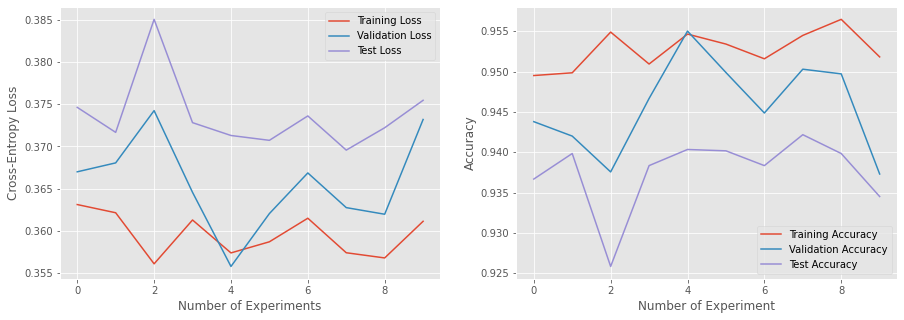

In [21]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiments')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

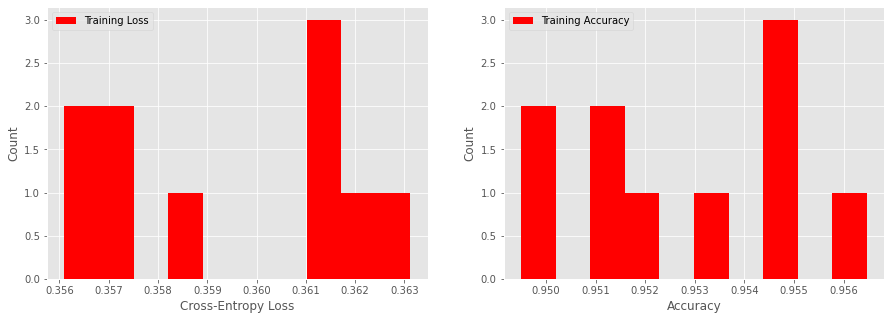

In [22]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.hist(exp_losses_train, label='Training Loss',color='r')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(train_acc_exp, label='Training Accuracy',color='r')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

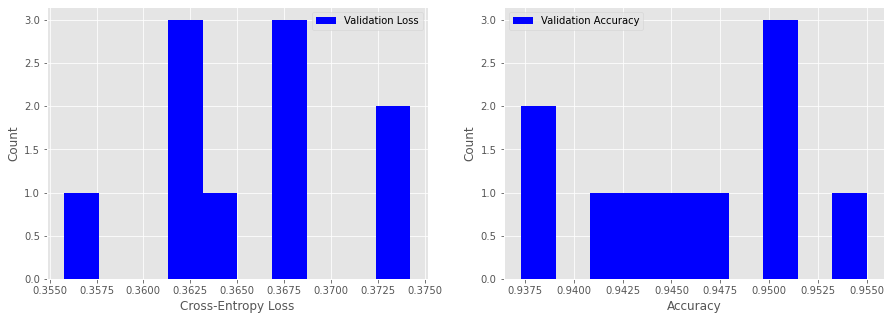

In [23]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(exp_losses_val, label='Validation Loss',color='b')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(val_acc_exp, label='Validation Accuracy',color='b')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

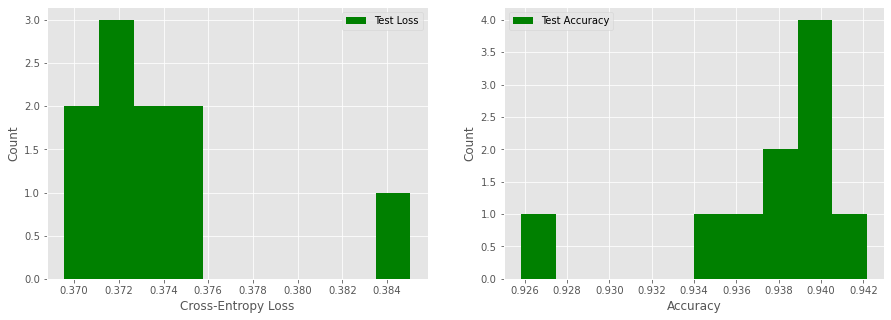

In [24]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(test_loss_exp, label='Test Loss',color='g')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='g')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()